In [88]:
from collections import defaultdict
import glob
import os
import json
import numpy as np
import re
from typing import Dict, List, Set, Tuple

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

output_dir = "/app/dataset/preprocess/exp2"
os.makedirs(output_dir, exist_ok=True)

#### Input collection

In [2]:
class Cap2Val:
    multipler = {"B": 1e9, "M": 1e6}
    
    @classmethod
    def cap2val(cls, s: str) -> int:
        num = s.split(".")[0]
        return int(float(num) * cls.multipler[s[-1]])


def load_all_hist_df_and_dates(glob_path: str) -> Tuple[List[pd.Timestamp], List[pd.DataFrame]]:
    hist_df_list = []
    date_list = []
    for path in sorted(glob.glob(glob_path)):
        date = pd.to_datetime(re.findall(r"(\d{4}-\d{2}-\d{2})", os.path.basename(path))[0])
        date_list += [date] * 7
        df = pd.read_excel(path)
        df["Market Cap"] = df["Market Cap"].apply(lambda x: Cap2Val.cap2val(x))
        hist_df_list += [df] * 7
    return date_list, hist_df_list


def get_top_n_tickers_in_window(hist_df_list_seg: List[pd.DataFrame], window_weights: List[float], top_n: int) -> List[str]:
    assert len(hist_df_list_seg) == len(window_weights)
    cap_dict = defaultdict(int)
    for df, day_weight in zip(hist_df_list_seg, window_weights):
        for _, row in df.iterrows():
            cap_dict[row["Ticker"]] += row["Market Cap"] * day_weight
    sorted_pairs = sorted(list(cap_dict.items()), key=lambda x: x[1], reverse=True)
    top_tickers = [tick for tick, cap in sorted_pairs[:top_n]]
    return top_tickers


def get_weights_of_top_tickers_in_window(hist_df_list_seg: List[pd.DataFrame], top_tickers: List[str]) -> pd.DataFrame:
    df_weights = pd.DataFrame(
        {
            f"weight_{i}": pd.Series(dtype='float') for i in range(len(top_tickers))
        }
    )
    ticker_indices = {tick: i for i, tick in enumerate(top_tickers)}
    for df in hist_df_list_seg:
        len_df_weights = len(df_weights)
        cap_sum = df["Market Cap"].sum()
        df["Weight"] = df["Market Cap"] / cap_sum
        for i, row in df.iterrows():
            if row["Ticker"] in ticker_indices:
                tick_idx = ticker_indices[row["Ticker"]]
                df_weights.at[len_df_weights, f"weight_{tick_idx}"] = row["Weight"]
    return df_weights


class TickerMapping:
    hist_to_price_dict = {"SHIB": "1000SHIB"}
    price_to_hist_dict = {"1000SHIB": "SHIB"}

    def hist_to_price(self, ticker: str) -> str:
        return self.hist_to_price_dict.get(ticker, ticker)

    def price_to_hist(self, ticker: str) -> str:
        return self.price_to_hist_dict.get(ticker, ticker)


def load_all_price_df(glob_path: str) -> Dict[str, pd.DataFrame]:
    ticker_mapping = TickerMapping()
    price_df_dict = {}
    for xlsx_path in glob.glob(glob_path):
        ticker = re.findall("(.*)USDT.xlsx", os.path.basename(xlsx_path))[0]
        ticker = ticker_mapping.price_to_hist(ticker)
        df = pd.read_excel(xlsx_path)
        price_df_dict[ticker] = df
    return price_df_dict


top_n = 15
window_weights = [1] * 12 * 7  # 12 weeks ~ 3 months ~ 84 days
window_size = len(window_weights)

In [3]:
date_list, hist_df_list = load_all_hist_df_and_dates("/app/dataset/raw/20250928_现货价格数据和历史排名数据/historical_data/*.xlsx")
print(len(hist_df_list))
print(date_list[0], hist_df_list[0].shape)

price_df_dict = load_all_price_df("/app/dataset/raw/20250928_现货价格数据和历史排名数据/price_data/*.xlsx")
print(len(price_df_dict))

2450
2019-01-03 00:00:00 (23, 2)
74


In [4]:
def fix_missing_len(df: pd.DataFrame, target_len: int):
    if len(df) == 0:
        df_padding = pd.DataFrame(1 + np.random.random((target_len, df.shape[1])), columns=df.columns)
        df = pd.concat([df, df_padding], axis=0)
    elif len(df) < target_len:
        df_padding = pd.DataFrame([df.mean()] * (target_len - len(df)), columns=df.columns)
        df = pd.concat([df, df_padding], axis=0)
    elif len(df) > target_len:
        df = df.iloc[:target_len]
    return df.reset_index(drop=True)


def normalize_df_price(df: pd.DataFrame) -> pd.DataFrame:
    df["volume"] = np.log(df["volume"])
    df = (df - df.min()) / (df.max() - df.min())
    return df

In [5]:
dataset = []
meta_list = []

for i in tqdm(range(len(hist_df_list) - window_size)):
    top_tickers = get_top_n_tickers_in_window(hist_df_list[i: i + window_size], window_weights, top_n)
    #print(top_tickers)
    df_weights = get_weights_of_top_tickers_in_window(hist_df_list[i: i + window_size], top_tickers)
    assert df_weights.shape == (window_size, len(top_tickers))
    #print(df_weights)
    date_start, date_end = date_list[i], date_list[i + window_size]
    meta = {"date_start": str(date_start), "date_end": str(date_end), "top_tickers": top_tickers}
    meta_list.append(meta)
    #print(date_start, date_end)
    #raise
    
    # iterate all tickers
    df = pd.DataFrame([0] * window_size, columns=["dummy"])
    for j, tick in enumerate(top_tickers):
        # extract tick within start-end date + fill missing
        df_price = price_df_dict[tick]
        df_price = df_price[(date_start <= df_price["date"]) & (df_price["date"] < date_end)]
        df_price = df_price.drop(columns=["date"]).reset_index(drop=True)
        df_price = fix_missing_len(df_price, window_size)
        assert df_price.shape == (window_size, df_price.shape[1])
        
        # normalize + reweighting
        df_price = normalize_df_price(df_price)
        df_price = df_price.mul(df_weights[f"weight_{j}"], axis=0)
        df_price = df_price.rename(columns=lambda x: f"{tick}_{x}_{j}")  # optional
        
        # horizontally concat
        df = pd.concat([df, df_price], axis=1)
    df = df.drop(columns=["dummy"])
    dataset.append(df.to_numpy())

dataset = np.stack(dataset, axis=0)
print(dataset.shape)  # (num_samples, window_size, num_features)
json.dump(meta_list, open(os.path.join(output_dir, "meta.json"), "w"), indent=4)
np.save(os.path.join(output_dir, "dataset.npy"), dataset)

  0%|          | 0/2366 [00:00<?, ?it/s]

100%|██████████| 2366/2366 [11:41<00:00,  3.37it/s]


(2366, 84, 75)


In [7]:
meta_list[0]

{'date_start': '2019-01-03 00:00:00',
 'date_end': '2019-03-28 00:00:00',
 'top_tickers': ['ETH',
  'XRP',
  'EOS',
  'BCH',
  'LTC',
  'XLM',
  'BNB',
  'TRX',
  'ADA',
  'IOTA',
  'XMR',
  'DASH',
  'NEO',
  'MKR',
  'ETC']}

#### Output calculator

In [207]:
def gen(days: int = 7, ticks: int = 16, transaction_fee_rate: float = 0.0002):
    model_output = (np.random.random((days, ticks)) - 0.5) * 3
    
    # change the last column (cash) to be non-negative
    model_output[:, -1] = np.abs(model_output[:, -1])
    
    # init investment combination for days
    comb_for_days = model_output / model_output.sum(axis=1, keepdims=True)
    assert np.abs(comb_for_days.sum(axis=1).sum() - 1 * days) < 1e-6

    # collect price variation for tickers
    meta = meta_list[0]
    start = pd.to_datetime(meta["date_end"])
    end = start + pd.Timedelta(days=days + 1)
    price_ratio_series_list = []  # pd.Series
    for tick in meta["top_tickers"][:ticks]:
        df_price = price_df_dict[tick]
        df_price = df_price[(start <= df_price["date"]) & (df_price["date"] < end)]
        df_price = df_price.reset_index(drop=True)
        df_price = fix_missing_len(df_price, days)
        assert df_price.shape == (days, df_price.shape[1])
        price_series = (df_price["open"] + df_price["close"]) / 2
        price_ratio_series = price_series.diff()[1:].reset_index(drop=True) / price_series[:-1]
        assert len(price_ratio_series) == days - 1  # e.g. 7 days -> 6 ratios
        price_ratio_series_list.append(price_ratio_series)

    # iterate days for changing
    money_comb = comb_for_days[0].copy()
    money_history = [1]
    for day in range(1, days):
        # iterate tickers in a day
        for i, price_ratio_series in enumerate(price_ratio_series_list):
            money_comb[i] = money_comb[i] * (1 + price_ratio_series[day - 1])
        turnover = np.abs(comb_for_days[day] - comb_for_days[day - 1]).sum()
        money = money_comb.sum()
        money = max(1e-12, money - money * turnover * transaction_fee_rate)
        money_history.append(float(money))
        money_comb = comb_for_days[day] * money  # reweighting
    
    # compute sharpe ratio
    excess_returns = np.array(money_history[1:]) / np.array(money_history[:-1]) - 1
    sharpe_ratio = excess_returns.mean() / (excess_returns.std() + 1e-6)
    # print(money_history, sharpe_ratio)

    return -sharpe_ratio

In [208]:
gen(days=7, ticks=4, transaction_fee_rate=0)

np.float64(-0.15093543208697474)

In [209]:
money_list = [gen(days=100, ticks=4, transaction_fee_rate=0) for _ in range(100)]

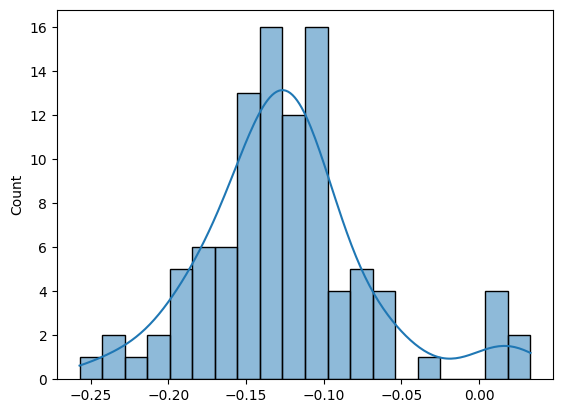

In [ ]:
sns.histplot(money_list, bins=20, kde=True)
plt.show()
print(np.array(sorted(money_list)[20:-20]).mean())